In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import (
    CRS,
    BBox,
    SHConfig,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    WmsRequest,
    MosaickingOrder
)
import getpass


## Preparation
### Credentials

In [2]:
#### Only run this cell if you have not created a configuration.
try:
    config = SHConfig("cdse")
except:
    config = SHConfig()
    config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
    config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
    config.instance_id = getpass.getpass("Enter an instance id")
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.save("cdse")

### Parameters of the Maschsee

In [29]:
maschsee_coords_wgs84 = (9.733200, 52.342366, 9.755344, 52.363231)
resolution = 10
maschsee_bbox = BBox(bbox=maschsee_coords_wgs84, crs=CRS.WGS84)
maschsee_size = bbox_to_dimensions(maschsee_bbox, resolution=resolution)

### Parameters of the Marienfelder See

In [30]:
marienfelder_see_coords_wgs84 = (7.830675785547997, 53.438630136848744, 7.834611272720725, 53.443047016038925)
resolution = 10
marienfelder_see_bbox = BBox(bbox=marienfelder_see_coords_wgs84, crs=CRS.WGS84)
marienfelder_see_size = bbox_to_dimensions(marienfelder_see_bbox, resolution=resolution)

### Define Time-Span
Here the last 60 days

In [31]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=60)  # specify how much you want to look back in time
tdelta_in_days = datetime.timedelta(days=1)  # specify the time delta
n_chunks = int((end - start) / tdelta_in_days)
edges = [(start + i * tdelta_in_days).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i] + 'T00:00:00+01:00', edges[i] + 'T23:59:59+01:00') for i in range(len(edges) - 1)]
slots

[('2025-03-31T00:00:00+01:00', '2025-03-31T23:59:59+01:00'),
 ('2025-04-01T00:00:00+01:00', '2025-04-01T23:59:59+01:00'),
 ('2025-04-02T00:00:00+01:00', '2025-04-02T23:59:59+01:00'),
 ('2025-04-03T00:00:00+01:00', '2025-04-03T23:59:59+01:00'),
 ('2025-04-04T00:00:00+01:00', '2025-04-04T23:59:59+01:00'),
 ('2025-04-05T00:00:00+01:00', '2025-04-05T23:59:59+01:00'),
 ('2025-04-06T00:00:00+01:00', '2025-04-06T23:59:59+01:00'),
 ('2025-04-07T00:00:00+01:00', '2025-04-07T23:59:59+01:00'),
 ('2025-04-08T00:00:00+01:00', '2025-04-08T23:59:59+01:00'),
 ('2025-04-09T00:00:00+01:00', '2025-04-09T23:59:59+01:00'),
 ('2025-04-10T00:00:00+01:00', '2025-04-10T23:59:59+01:00'),
 ('2025-04-11T00:00:00+01:00', '2025-04-11T23:59:59+01:00'),
 ('2025-04-12T00:00:00+01:00', '2025-04-12T23:59:59+01:00'),
 ('2025-04-13T00:00:00+01:00', '2025-04-13T23:59:59+01:00'),
 ('2025-04-14T00:00:00+01:00', '2025-04-14T23:59:59+01:00'),
 ('2025-04-15T00:00:00+01:00', '2025-04-15T23:59:59+01:00'),
 ('2025-04-16T00:00:00+0

Or use a wms request to get all flyovers.

With the Process API we can only ever download one image at a time. So our goal is to first get a list of all dates for which there is an image of the Maschsee available within our desired timeframe. Afterwards we can use these dates to send one request for each date and download the images automatically, one by one.First, we use a WmsRequest with the get_dates() method. This will not request any images, but only a list of the dates and times at which an image of the region, defined in the bounding box, was taken.For that we first need to define an instance_id for the SHConfig. To retrieve it, go the the Configuration Utility on the dashboard of your account on the Sentinel Hub Website. You can then use the Simple WMS Template. [If it is not there yet](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#copernicus-data-space-ecosystem-configuration), create it by clicking on New Configuration and select it under Select from existing instances. Afterwards, it should be there in the Configuration Utility.

In [32]:
time_frame = (start, end)
wms_request_with_deltat = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L2A,
    layer="ALL-BANDS-TRUE-COLOR",
    bbox=maschsee_bbox,
    time=time_frame,
    width=maschsee_size[0],
    image_format=MimeType.TIFF,
    time_difference=datetime.timedelta(hours=2),
    config=config,
)
edges = wms_request_with_deltat.get_dates()
slots = [(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00') for dt in edges]
slots

[('2025-03-31T00:00:00+01:00', '2025-03-31T23:59:59+01:00'),
 ('2025-04-03T00:00:00+01:00', '2025-04-03T23:59:59+01:00'),
 ('2025-04-08T00:00:00+01:00', '2025-04-08T23:59:59+01:00'),
 ('2025-04-10T00:00:00+01:00', '2025-04-10T23:59:59+01:00'),
 ('2025-04-13T00:00:00+01:00', '2025-04-13T23:59:59+01:00'),
 ('2025-04-18T00:00:00+01:00', '2025-04-18T23:59:59+01:00'),
 ('2025-04-20T00:00:00+01:00', '2025-04-20T23:59:59+01:00'),
 ('2025-04-23T00:00:00+01:00', '2025-04-23T23:59:59+01:00'),
 ('2025-04-28T00:00:00+01:00', '2025-04-28T23:59:59+01:00'),
 ('2025-04-30T00:00:00+01:00', '2025-04-30T23:59:59+01:00'),
 ('2025-05-03T00:00:00+01:00', '2025-05-03T23:59:59+01:00'),
 ('2025-05-08T00:00:00+01:00', '2025-05-08T23:59:59+01:00'),
 ('2025-05-10T00:00:00+01:00', '2025-05-10T23:59:59+01:00'),
 ('2025-05-13T00:00:00+01:00', '2025-05-13T23:59:59+01:00'),
 ('2025-05-18T00:00:00+01:00', '2025-05-18T23:59:59+01:00'),
 ('2025-05-20T00:00:00+01:00', '2025-05-20T23:59:59+01:00'),
 ('2025-05-23T00:00:00+0

### Define the Script
The custom script is executed on the server side. This one is taken from [SentinelHub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/apa_script/).

In [3]:
evalscript_apa = """//VERSION=3
//indices to apply a mask to water bodies

let moisture = (B8A-B11)/(B8A+B11); 
let NDWI = (B03 - B08)/(B03 + B08);
let water_bodies = (NDWI-moisture)/(NDWI+moisture);
//indices to identify water plants and algae

let water_plants = (B05 - B04)/(B05 + B04);
let NIR2 = B04 + (B11 - B04)*((832,8 - 664,6)/(1613,7 - 664,6));
let FAI = B08 - NIR2;
//indices to apply a mask over clouds

//code taken from sentinel-2 custom scripts cby_cloud_detection by Peter Fogh

let bRatio = (B03 - 0.175) / (0.39 - 0.175);
let NDGR = index(B03, B04);
let gain = 2.5;
// natural color composition

let natural_color = [3*B04, 3*B03, 3*B02];
// cloud mask

function clip(a) {
 return Math.max(0, Math.min(1, a));
}

if (B11 > 0.1){
  if (bRatio > 1) { //cloud

     var v = 0.5*(bRatio - 1);
     return natural_color;
  }
  else if (bRatio > 0 && NDGR>0) { //cloud

     var v = 5 * Math.sqrt(bRatio * NDGR);
     return natural_color;
  }
}
//classify the presence of algae and water plants over water surfaces

if (NDWI < 0 && water_bodies > 0) return natural_color;
else return [FAI*8.5, water_plants*5.5, NDWI*1];
"""

Then we define a helper script for handling the download-requests

In [34]:
max_cloud_coverage = 0.15


def get_sentinel_request(time_interval, evalscript, save_dir=None):
    return SentinelHubRequest(
        evalscript=evalscript,
        data_folder=save_dir,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
                maxcc=max_cloud_coverage
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=maschsee_bbox,  #
        size=maschsee_size,  # size of the output image we want to retrieve
        config=config,  # configuration defined at the top (Sentinel Hub credentials)
    )

... and a script to plot the images

In [35]:
def plot_images(data_and_dates: dict):
    ncols = 4
    nrows = 1 if ncols >= len(data_and_dates.keys()) else int(len(data_and_dates.keys()) / ncols)
    aspect_ratio = 1.5
    subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

    fig, axs = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(2 * ncols * aspect_ratio, 5 * nrows),
        subplot_kw=subplot_kw,
    )

    for idx, date in enumerate(sorted(data_and_dates)):
        path = data_and_dates[date]
        image = rasterio.open(path)
        ax = axs[idx // ncols][idx % ncols] if nrows > 1 else axs[idx]
        ax.imshow(np.moveaxis(image.read(), 0,
                              2))  # when the image is loaded with the read() function, the axes have to be moved.
        ax.set_title(f"{date.split('T')[0]}", fontsize=10)

## Download and filter the data
### Download it

In [38]:
import os

save_dir = './test_apa/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

COPERNICUS_API_URL = "https://sh.dataspace.copernicus.eu/api/v1/process"  # due to a bug, this needs later to be set for the dl-requests

list_of_requests = [get_sentinel_request(slot, evalscript=evalscript_apa, save_dir=save_dir) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]
for dl_item in list_of_requests:
    dl_item.url = COPERNICUS_API_URL

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
data = [d for d in data if np.max(d) - np.min(d) > 0.0]  # filter empty data

### Filter the downloaded data
Some downloaded images contain no info due to cloudcoverage. If they contain no data, the folder is removed.

In [42]:
import glob
import rasterio
from pathlib import Path
import shutil
import json

dl_data = glob.iglob(save_dir + '*/*.tiff', recursive=True)
for dl in dl_data:
    dl = Path(dl)
    img = rasterio.open(dl)
    if np.var(img.read()) == 0.0:
        shutil.rmtree(dl.parent)

# get date and data pairs from downloaded data
dl_data = glob.iglob(save_dir + '*/*.tiff', recursive=True)
data_and_dates = dict()
for dl in dl_data:
    dl = Path(dl)
    with open('/'.join(dl.parts[:-1]) + '/request.json', 'r') as file:
        request_data = json.load(file)
    date = request_data['request']['payload']['input']['data'][0]['dataFilter']['timeRange']['from'].split('T')[0]
    data_and_dates[date] = dl

#plot_images(data_and_dates)

### Crop the remaining images to the lake boundaries

In [5]:
import osmnx as ox
import os
lake_query = 'Maschsee, Hannover, Germany'
try:
    lake_gdf = ox.features_from_place(lake_query, tags={"natural": "water"})
    if lake_gdf.empty:
        lake_gdf = ox.features_from_address(lake_query.split(",")[0],
                                            tags={"natural": "water"})
except Exception as e:
    print(f"OSM Error for {lake_query}: {e}")

if not (lake_gdf is None):
    result = {"name": lake_query.split(",")[0], "found": True, "gdf": lake_gdf}

folder_name = f"{result['name']}"
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except FileExistsError:
        print(f"One or more directories in '{folder_name}' already exist.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{folder_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

file_name = f"{folder_name}/{result['name']}_boundaries.shp"
result['gdf'].to_file(file_name)

/tmp/ipykernel_21908/1589641892.py:27: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result['gdf'].to_file(file_name)
/home/cmanss/.virtualenvs/haix_aoi_detector/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'TMC:cid_58:tabcd_1:Class' to 'TMC_cid_58'
  ogr_write(
/home/cmanss/.virtualenvs/haix_aoi_detector/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'TMC:cid_58:tabcd_1:LCLversion' to 'TMC_cid__1'
  ogr_write(
/home/cmanss/.virtualenvs/haix_aoi_detector/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'TMC:cid_58:tabcd_1:LocationCode' to 'TMC_cid__2'
  ogr_write(
/home/cmanss/.virtualenvs/haix_aoi_detector/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'heritage:operator' to 'heritage_o'
  ogr_write(
/home/cmanss/.virtualenvs/hai

{'2025-05-13': PosixPath('test_apa/9d54df41f4dedc6738614005b2425b0b/cropped_response.tiff'), '2025-04-20': PosixPath('test_apa/e876fae242d3afebf733c46b6ec587db/cropped_response.tiff'), '2025-04-03': PosixPath('test_apa/f930f3c295dea7895c0c916a886cad31/cropped_response.tiff'), '2025-04-30': PosixPath('test_apa/017dec3faa175fc4d2b8b8695bbf3d7d/cropped_response.tiff')}


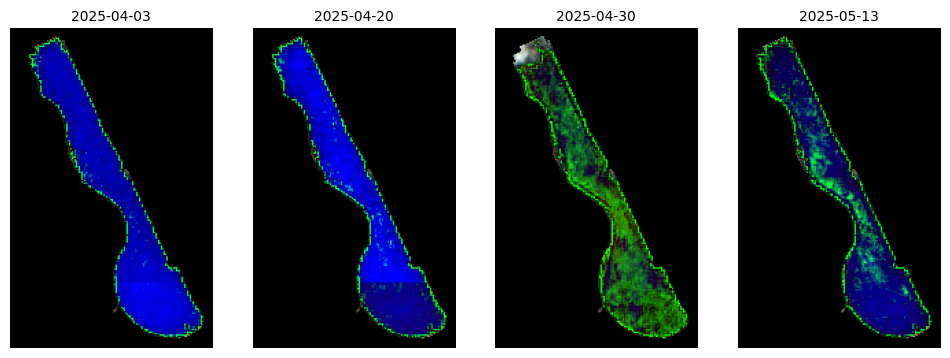

In [115]:
src_no_data = 0
dst_no_data = 0
maschsee_shp = '../assets/shapefiles/vector/00_NI_maschsee_shapefile/00_NI_maschsee_shapefile.shp'
#maschsee_shp = file_name
input_img_paths = glob.iglob(save_dir + '*/[!c]*.tiff')
for img_path in input_img_paths:
    img_path = Path(img_path)
    img_id = 'cropped_' + Path(img_path).stem
    img_out_path = img_path.parent / (str(img_id) + '.tiff')
    command = f"gdalwarp -dstnodata NoData -cutline {maschsee_shp} {img_path} {img_out_path}"
    _ = os.system(command + "> /dev/null 2>&1")  # put output and errors into /dev/null

# get date and data pairs from downloaded data
dl_data = [f for f in glob.iglob(save_dir + '*/cropped_response.tiff', recursive=True)]
data_and_dates = dict()
for dl in dl_data[:4]:
    dl = Path(dl)
    with open('/'.join(dl.parts[:-1]) + '/request.json', 'r') as file:
        request_data = json.load(file)
    date = request_data['request']['payload']['input']['data'][0]['dataFilter']['timeRange']['from'].split('T')[0]
    data_and_dates[date] = dl

print(data_and_dates)
plot_images(data_and_dates)

## Cluster the cropped images to get areas of interest

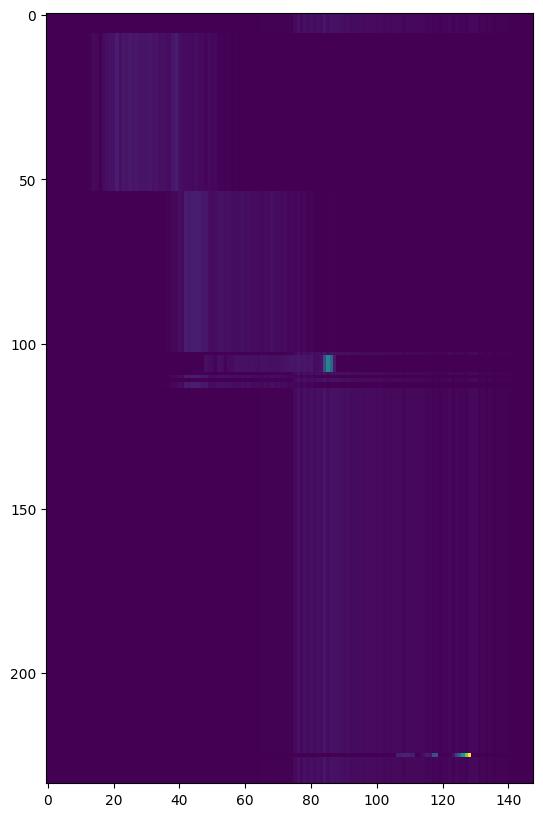

In [116]:
import cv2

latest_key = list(data_and_dates.keys())[0]

image = rasterio.open(data_and_dates[latest_key])
img = np.moveaxis(image.read(), 0, 2)

vectorized_img = img.reshape((-1, 3))[...,1]  # only take green channel
vectorized_img = np.float32(vectorized_img)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5  # [none, low, medium, high, vegetation]
attempts = 10
ret, label, center = cv2.kmeans(vectorized_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape[:2]))

plt.figure(figsize=(15, 10))
plt.imshow(result_image)

In [107]:
categories = ['none', 'low', 'medium', 'high', 'vegetation']
sorted_center_args = {k: v for k, v, in zip (categories, center.flatten().argsort())}
sorted_centers = {k: v[0] for k, v in zip(categories, center[list(sorted_center_args.values())])}
sorted_center_args

{'none': 1, 'low': 4, 'medium': 0, 'high': 3, 'vegetation': 2}

In [108]:
sorted_centers

{'none': 0, 'low': 37, 'medium': 86, 'high': 149, 'vegetation': 245}

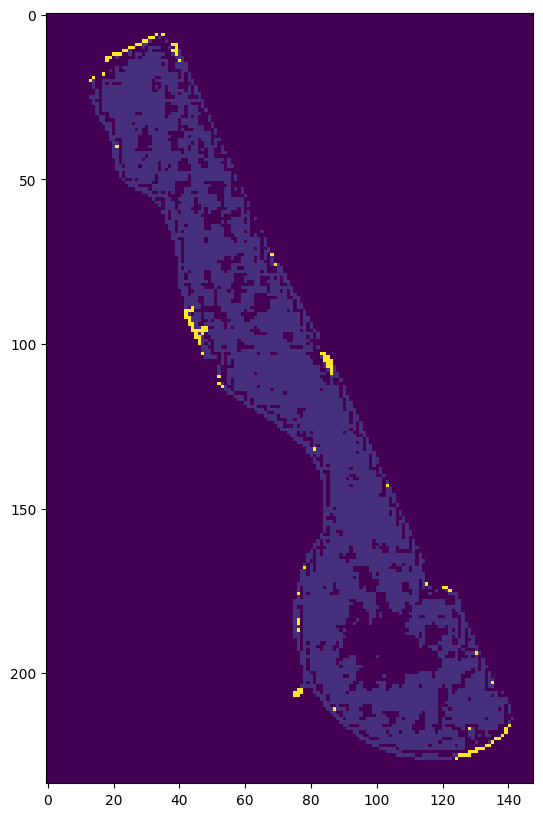

In [65]:
latest_key = list(data_and_dates.keys())[0]

image = rasterio.open(data_and_dates[latest_key])
img = np.moveaxis(image.read(), 0, 2)

vectorized_img = img.reshape((-1, 3))[...,0]  # only take red channel -> FAI
vectorized_img = np.float32(vectorized_img)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # [none, maybe, vegetation]
attempts = 10
ret_r, label_r, center_r = cv2.kmeans(vectorized_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center_r = np.uint8(center_r)
res_r = center_r[label_r.flatten()]
result_image_r = res_r.reshape((img.shape[:2]))

plt.figure(figsize=(15, 10))
plt.imshow(result_image_r)

### Get the GPS coordinates from Raster

In [114]:
band1 = image.read(1)
height = band1.shape[0]
width = band1.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(image.transform, rows, cols)
lons = np.array(xs)
lats = np.array(ys)

gps = np.array(list(zip(lons.ravel(), lats.ravel())))
positions = gps[
    np.argwhere(np.logical_or(sorted_center_args['medium'] == label, label == sorted_center_args['high']))[:, 0]]  # filter positions for label. Here the label can change. todo: detect correct label
print(positions)

[[ 9.73821232 52.36265142]
 [ 9.73851157 52.36265142]
 [ 9.73791308 52.36256225]
 ...
 [ 9.75227676 52.34312392]
 [ 9.75242638 52.34312392]
 [ 9.75182789 52.34303475]]


### Cluster the points

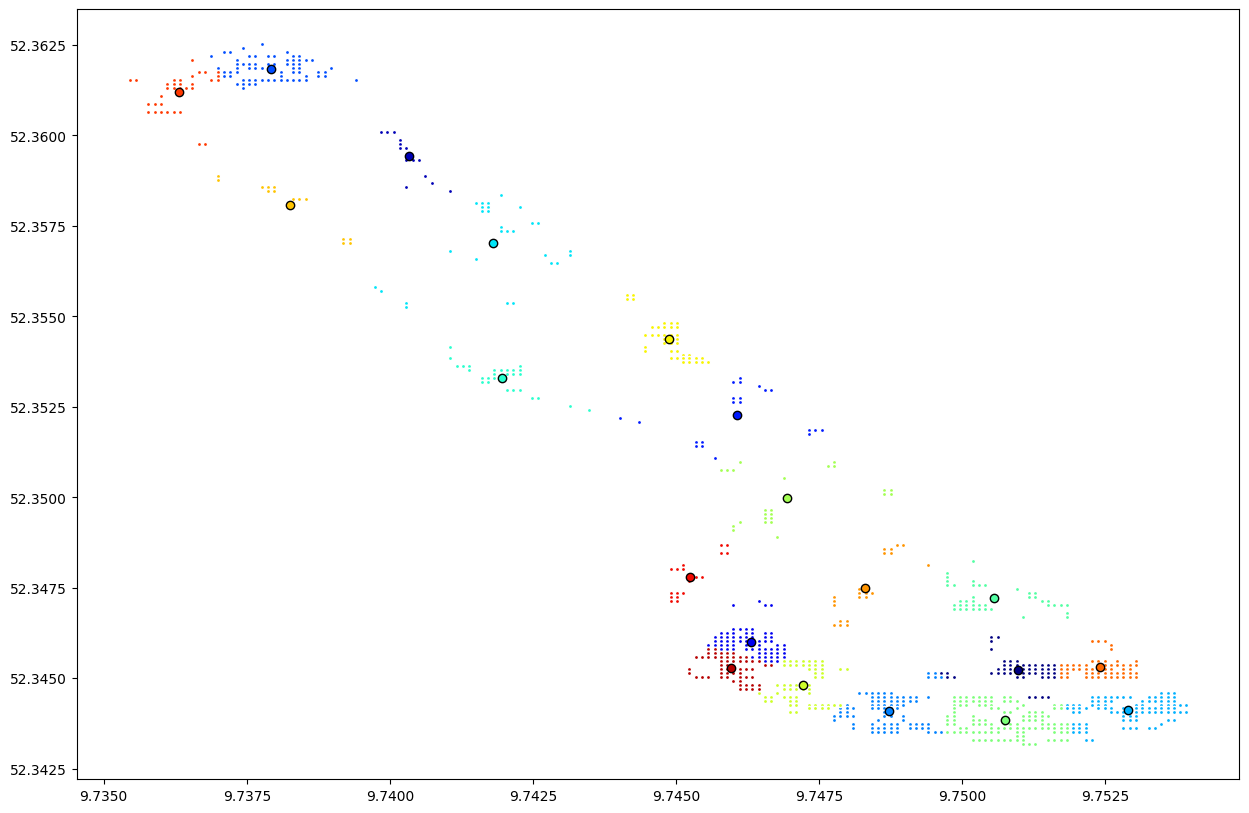

In [14]:
from sklearn.metrics.pairwise import pairwise_distances_argmin
import matplotlib
from sklearn.cluster import KMeans

n_clusters = 20

norm = matplotlib.colors.Normalize(vmin=0, vmax=n_clusters)
colors = [plt.cm.jet(norm(i)) for i in range(n_clusters)]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(positions)
k_means_cluster_centers = kmeans.cluster_centers_

k_means_labels = pairwise_distances_argmin(positions, k_means_cluster_centers)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(positions[my_members, 0], positions[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )

### Create Polygons out of the clustered regions and sort them according to points
Here, we assume that if a cluster has more points, it is more important to weed.

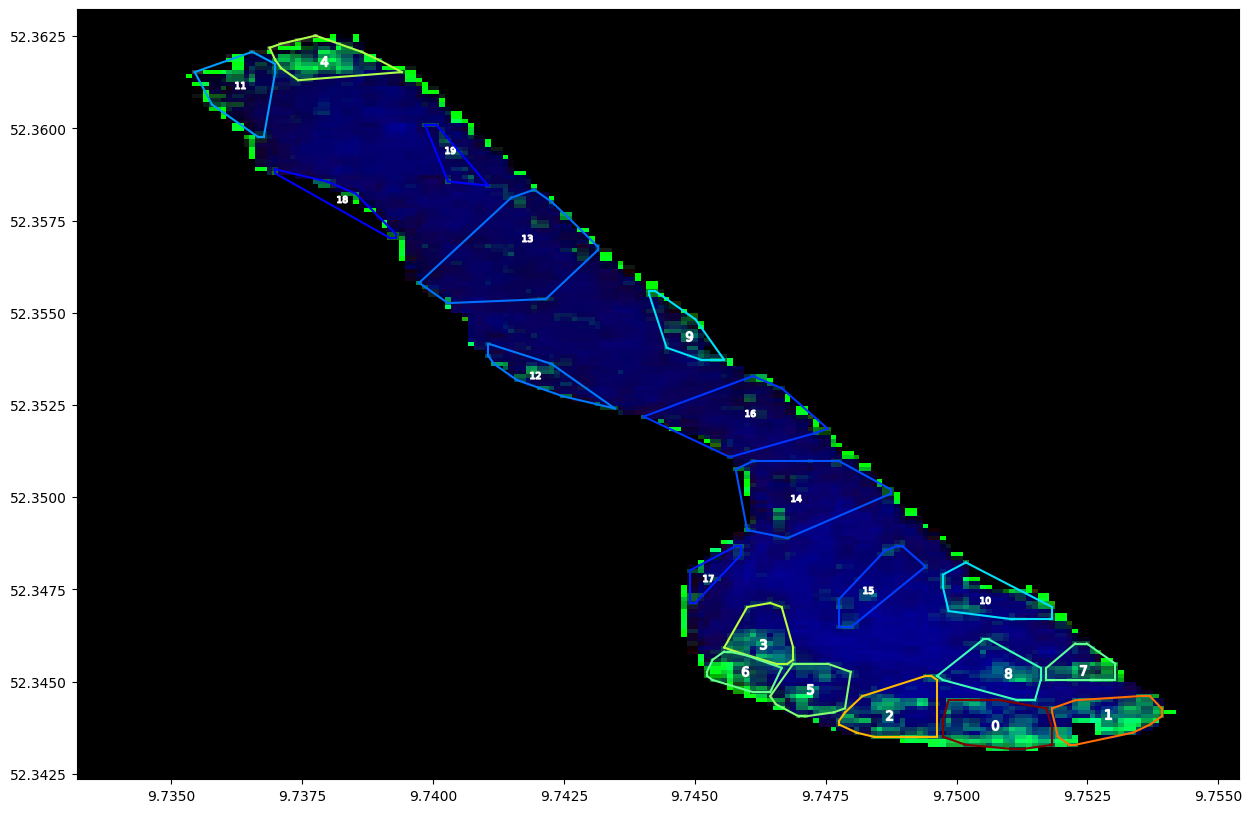

In [15]:
from scipy.spatial import ConvexHull

k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels = pairwise_distances_argmin(positions, k_means_cluster_centers)

members_per_cluster = [positions[k_means_labels == k, :].shape[0] for k in range(n_clusters)]
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(members_per_cluster))
colors = [plt.cm.jet(norm(members_per_cluster[k])) for k in range(n_clusters)]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
list_of_areas = list()
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    member_positions = positions[my_members, :]
    n_member_positions = member_positions.shape[0]
    cluster_center = k_means_cluster_centers[k]
    hull = ConvexHull(member_positions)
    list_of_areas.append(hull)
    for simplex in hull.simplices:
        ax.plot(member_positions[simplex, 0], member_positions[simplex, 1], linestyle='-', color=col)

sorted_clusters = k_means_cluster_centers[np.argsort(members_per_cluster), :][::-1]

image = rasterio.open(data_and_dates[latest_key])
img = np.moveaxis(image.read(), 0, 2)
ax.pcolormesh(gps[:, 0].reshape(img.shape[:2]), gps[:, 1].reshape(img.shape[:2]), img, rasterized=True)

for i, c in enumerate(sorted_clusters):
    ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor='w')

## Forward the data to the next processing step

In [16]:
import csv

a_idx = 0
with open('single_area_of_interest.csv', 'w') as file:
    writer = csv.writer(file)
    points = list_of_areas[a_idx].points
    simplex = list_of_areas[a_idx].simplices
    writer.writerows(points[list_of_areas[a_idx].vertices, :])

In [17]:
with open('areas_of_interest.csv', 'w') as file:
    writer = csv.writer(file)
    for a_idx, area in enumerate(list_of_areas):
        points = area.points
        vertices = area.vertices
        rows = np.hstack([a_idx * np.ones((vertices.shape[0], 1)), points[vertices, :]])
        writer.writerows(rows)

In [20]:
import sys
sys.path.append('../')
from src.utils import save_areas_of_interests_to_json

areas_of_interests = [a.points[a.vertices, :].tolist() for a in list_of_areas]
save_areas_of_interests_to_json(areas_of_interests, 'areas_of_interests.json')